In [168]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split

In [169]:
def generate_dataset(mus, sigmas, class_samples_size, save_path):
    dataset = pd.DataFrame(data={'X1': [], 'X2': [], 'Y':[]})
    for i in range(len(mus)):
        x1, x2 = np.random.multivariate_normal(mus[i], sigmas[i], class_samples_size).T
        ds_class_i = pd.DataFrame(data={'X1': x1, 'X2': x2, 'Y': [i] * class_samples_size})
        dataset = pd.concat([dataset, ds_class_i], axis=0)
    dataset.to_csv(save_path, index=False)
    return dataset

# ----> Run once to generate data <----
mu_ds_1 = \
    [[2,5],
    [8,1],
    [5,3]]

sigma_ds_1 = \
    [[[2,0], [0,2]],
    [[3,1], [1,3]],
    [[2,1], [1,2]]]

# dataset = generate_dataset(mu_ds_1, sigma_ds_1, 500, 'datasets/NPE_dataset.csv')

In [170]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data.to_numpy()

data = load_data('datasets/NPE_dataset.csv')

In [171]:
def estimate_density(x1, x2 ,hists, xedges, yedges, n, width):
    xedges, yedges = xedges[1:], yedges[1:]
    for i, x in enumerate(xedges):
        if x1 < x:
            for j, y in enumerate(yedges):
                if x2 < y:
                    num_smaples = hists[i,j]
                    bin_area = width[0] * width[1]
                    return 1/n * (num_smaples / bin_area)

def hist_estimate(train_data, test_data, h):
    train_X1 = train_data[:, 0]
    train_X2 = train_data[:, 1]
    test_X1 = test_data[:, 0]
    test_X2 = test_data[:, 1]
    xedges, yedges = np.arange(np.min(train_X1), np.max(train_X1), h), np.arange(np.min(train_X2), np.max(train_X2), h)
    hist, xedges, yedges = np.histogram2d(train_X1, train_X2, bins=(xedges, yedges))
    n = data.shape[0]

    X, Y = np.meshgrid(test_X1, test_X2)
    Z = np.zeros(X.shape)

    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            Z[i,j] = estimate_density(X[i,j], Y[i,j] ,hist, xedges, yedges, n, [h, h])

    return Z

def plot_histograms(data, h):
    X1 = data[:, 0]
    X2 = data[:, 1]
    xedges, yedges = np.arange(np.min(X1), np.max(X1), h), np.arange(np.min(X2), np.max(X2), h)
    hist, xedges, yedges = np.histogram2d(X1, X2, bins=(xedges, yedges))

    X, Y = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    Z = 0
    dx = dy = 0.5 * np.ones_like(Z)
    dz = hist.ravel()

    fig1, ax1 = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))
    ax1.bar3d(X.ravel(), Y.ravel(), Z, dx, dy, dz, zsort='average')
    plt.show()

    fig3, axs = plt.subplots(1, 2, figsize=(30,10))
    axs[0].hist(X1, bins=np.arange(np.min(X1), np.max(X1) + h, h), edgecolor="white")
    axs[0].set_ylabel('count')
    axs[0].set_xlabel('data')
    
    axs[1].hist(X2, bins=np.arange(np.min(X2), np.max(X2) + h, h), edgecolor="white")
    axs[1].set_ylabel('count')
    axs[1].set_xlabel('data')
    plt.show()


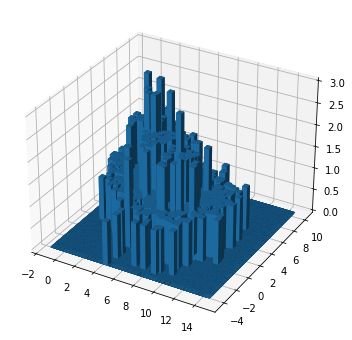

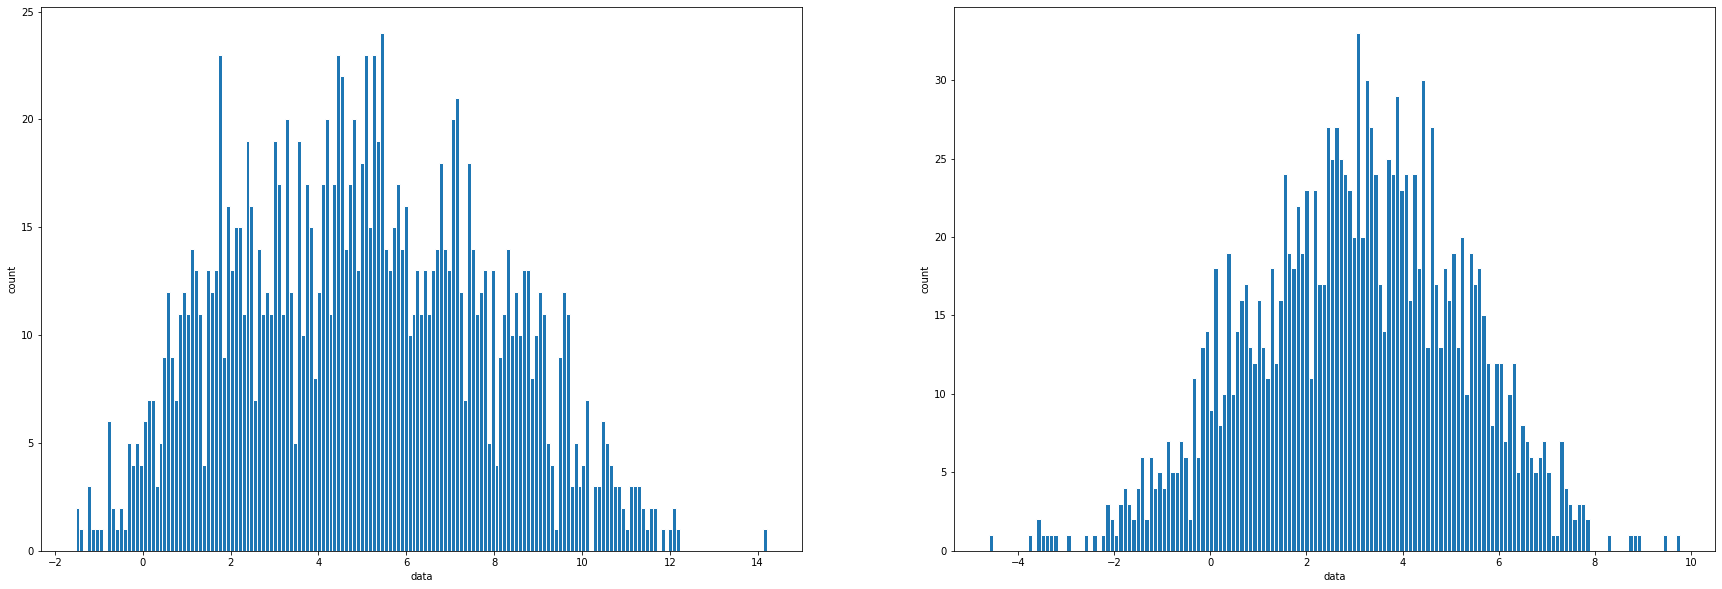

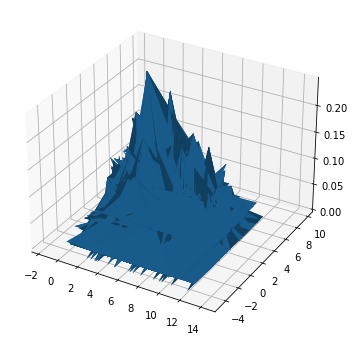

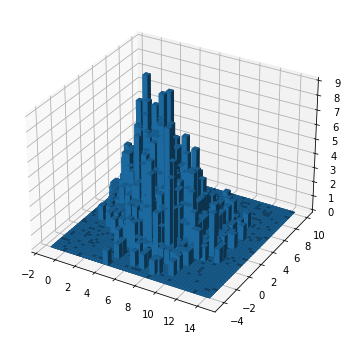

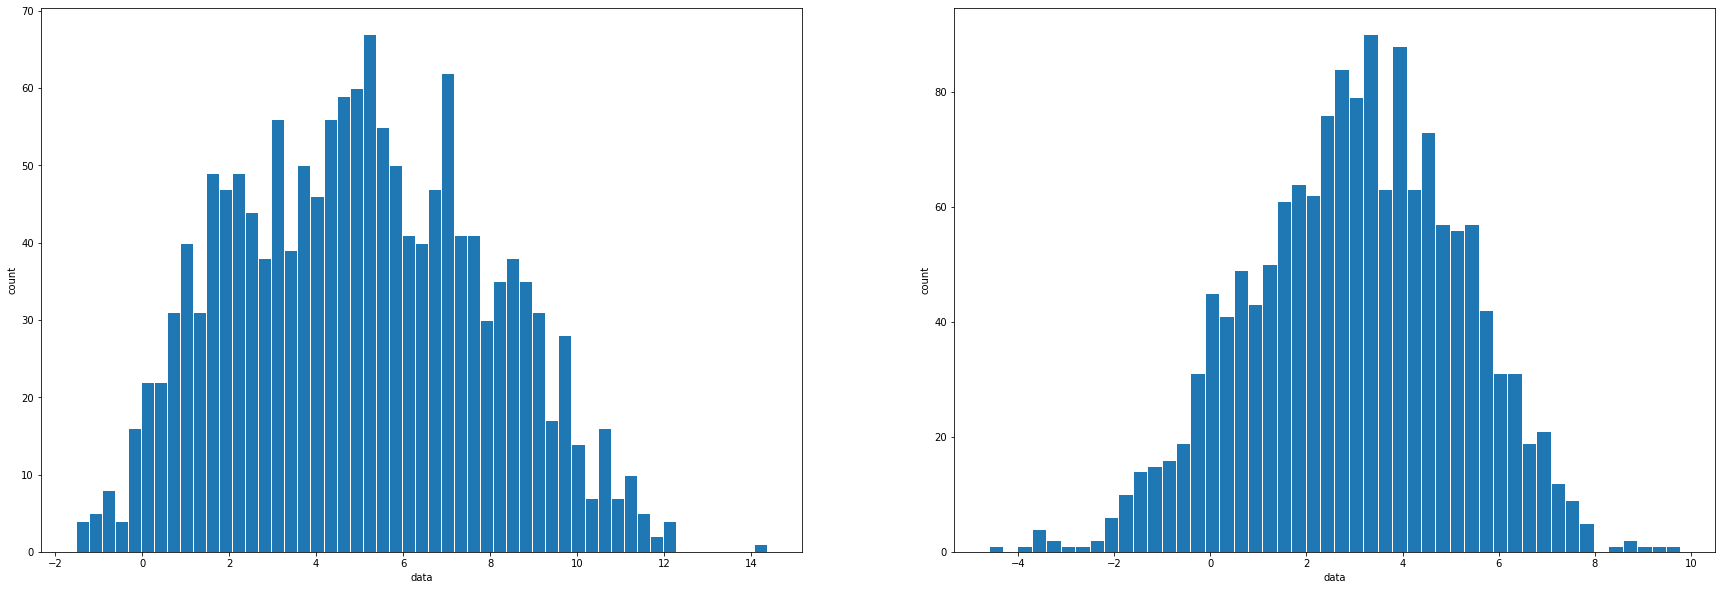

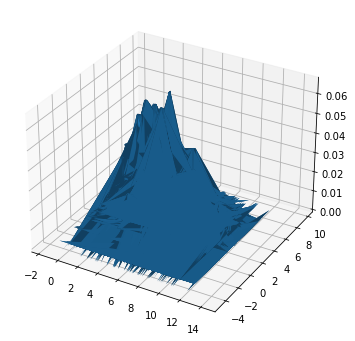

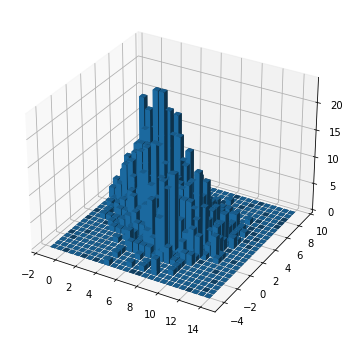

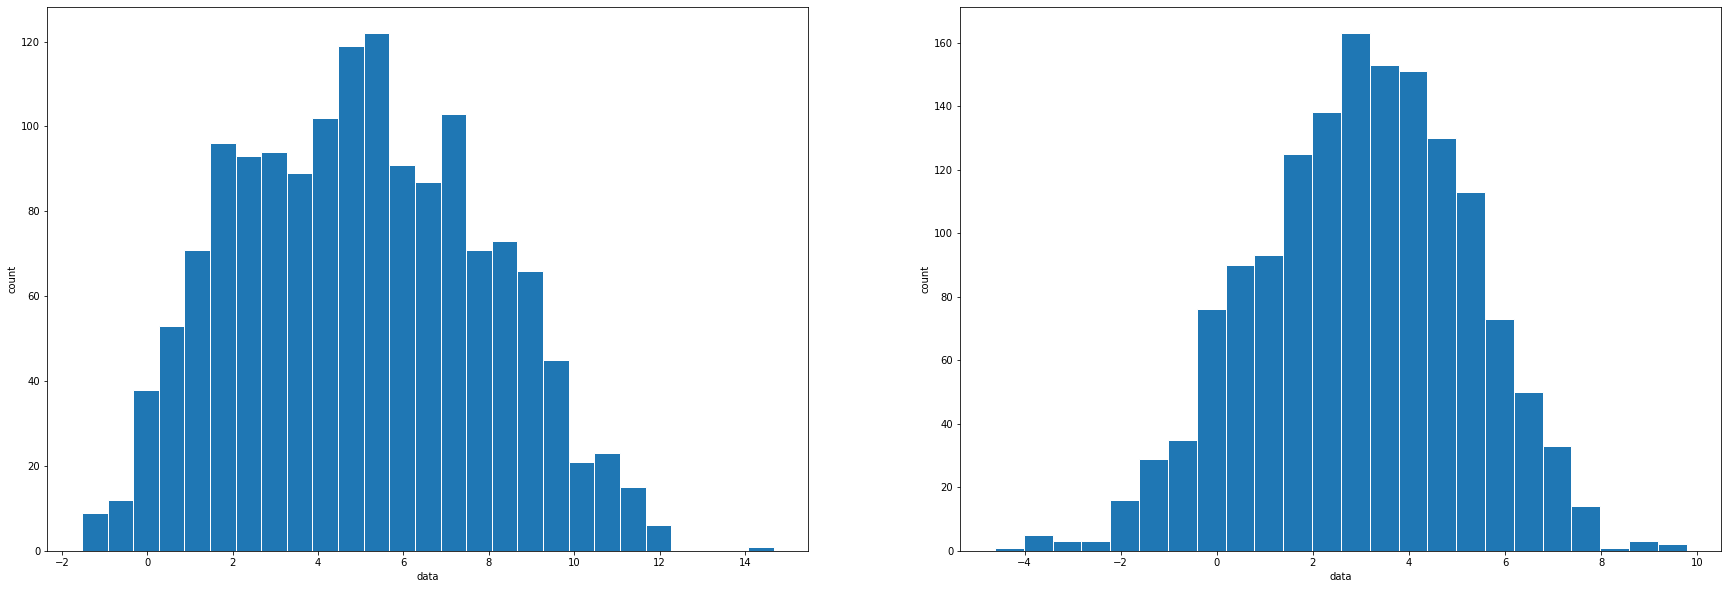

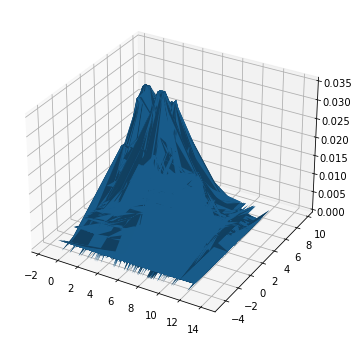

In [172]:
h_s = [0.09, 0.3, 0.6]

train_data, test_data = train_test_split(data, stratify=data[:, -1], test_size=0.2)
X_train = np.array(train_data[:, :-1])
X_test = np.array(train_data[:, :-1])

hist_estimates = []
for i, h in enumerate(h_s):
    plot_histograms(data, h)
    hist_estimates.append(hist_estimate(X_train, X_test, h))
    
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))
    X, Y = np.meshgrid(X_test[:, 0], X_test[:, 1])
    surf = ax.plot_surface(X, Y, hist_estimates[i])
    plt.show()

In [173]:

def gaussian_kernel(x, sigma):
    return (((1/(math.sqrt(2*math.pi)) * sigma)) * math.exp(-(1/2) * (x**2) * (sigma**2)))

def parzan_window(u, bw = (1/2)):
    if ((np.abs(u)) <= (np.abs(bw))):
        return 1
    else:
        return 0

def kernel_function(X, h, data_point, sigma, kernel_type):
    data_length = len(data_point)
    products = 1
    if(kernel_type == 'parzen'):
        for i in range(0, data_length):
            products *= parzan_window((X[i] - data_point[i])/h, sigma)
    if(kernel_type == 'gaussian'):
        for i in range(0, data_length):
            products *= gaussian_kernel((X[i] - data_point[i])/h, sigma)
    return products

def KDE(X_data, h, X_cord_2d, sigma, kernel_type):
    N = X_data.shape[0]
    d = X_data.shape[1]
    probs = []  

    for x in X_cord_2d:
        px = (1/(N * (h**d))) * np.sum([kernel_function(x, h, x_i, sigma, kernel_type) for x_i in X_data])
        probs.append(px) 

    return probs

In [174]:
X_data = data[:, :-1]

x = np.linspace(np.min(X_data[:, 0]), np.max(X_data[:, 0]), 40).reshape(-1, 1)
y = np.linspace(np.min(X_data[:, 1]), np.max(X_data[:, 1]), 40).reshape(-1, 1)
X_cord, Y_cord = np.meshgrid(x, y)

X_cord_2d = np.concatenate([X_cord.ravel().reshape(-1, 1), Y_cord.ravel().reshape(-1, 1)], axis=1)

prior = [1/3, 1/3, 1/3]
Z_cord_true = 0
for i in range(len(mu_ds_1)):
    Z_cord_true += (prior[i] * multivariate_normal(mu_ds_1[i], sigma_ds_1[i]).pdf(X_cord_2d))
Z_cord_true = np.array(Z_cord_true).reshape(X_cord.shape)

In [175]:
parzen_probs = []
for h in h_s:
    print(f"calculating probabilities with KDE (kernel = parzen window) using h = {h}")
    probs = KDE(X_data, h, X_cord_2d, (1/2), 'parzen')
    probs = np.array(probs).reshape(X_cord.shape)
    parzen_probs.append(probs)

calculating probabilities with KDE (kernel = parzen window) using h = 0.09
calculating probabilities with KDE (kernel = parzen window) using h = 0.3
calculating probabilities with KDE (kernel = parzen window) using h = 0.6


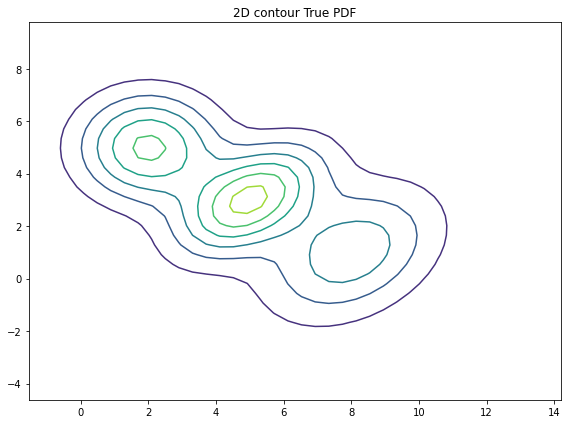

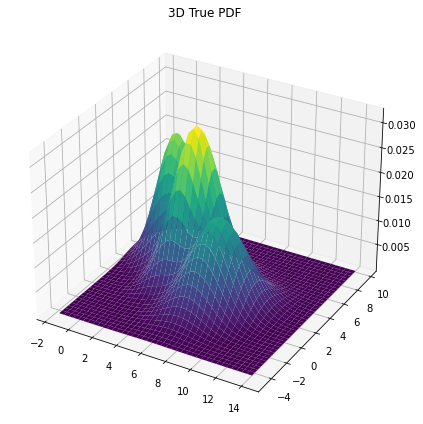

In [176]:
fig1, ax1 = plt.subplots(1, figsize=(8, 6))
ax1.contour(X_cord, Y_cord, Z_cord_true)
ax1.set_title('2D contour True PDF')
fig1.tight_layout()

fig2, ax2 = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))
ax2.plot_surface(X_cord, Y_cord, Z_cord_true, cmap="viridis")
ax2.set_title('3D True PDF')
fig2.tight_layout()

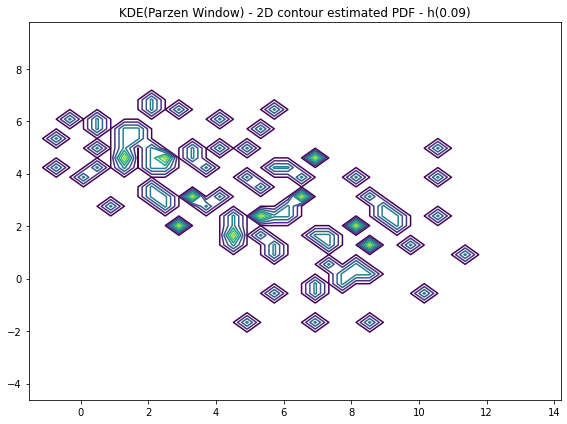

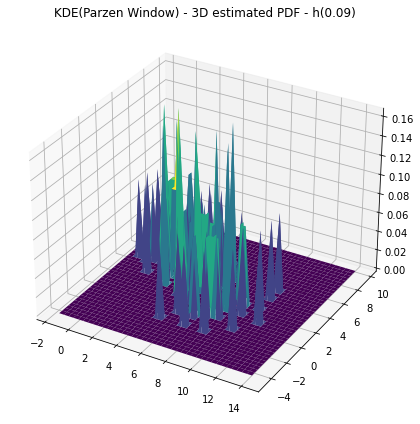

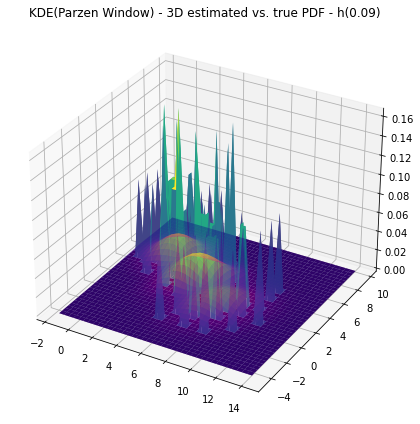

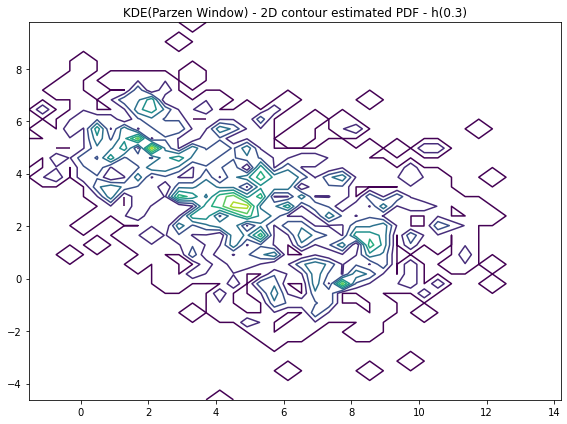

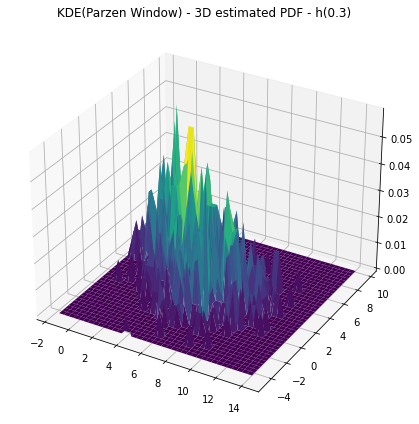

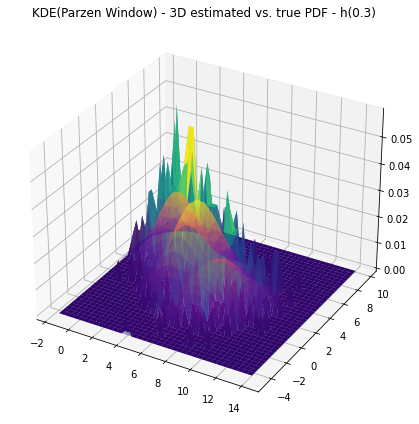

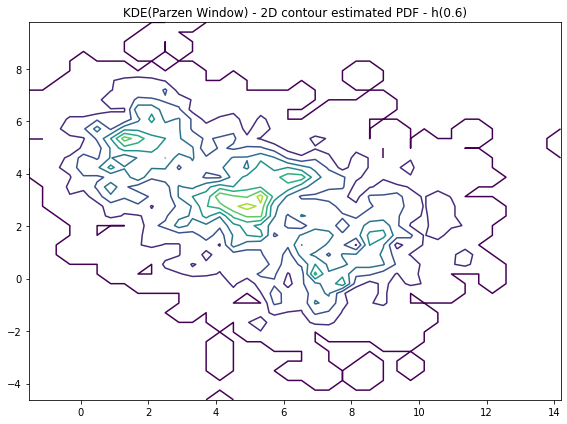

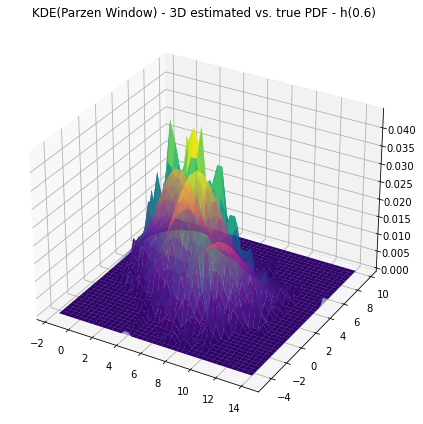

In [177]:
for i in range(len(h_s)):
    fig1, ax1 = plt.subplots(1, figsize=(8, 6))
    ax1.contour(X_cord, Y_cord, parzen_probs[i])
    ax1.set_title(f'KDE(Parzen Window) - 2D contour estimated PDF - h({str(h_s[i])})')
    fig1.tight_layout()

    fig2, ax2 = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))
    ax2.plot_surface(X_cord, Y_cord, parzen_probs[i], cmap="viridis")
    ax2.set_title(f'KDE(Parzen Window) - 3D estimated PDF - h({str(h_s[i])})')
    fig2.tight_layout()

    fig3, ax3 = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))
    ax3.plot_surface(X_cord, Y_cord, Z_cord_true, cmap="plasma", alpha=0.4)
    ax3.plot_surface(X_cord, Y_cord, parzen_probs[i], cmap="viridis")
    ax3.set_title(f'KDE(Parzen Window) - 3D estimated vs. true PDF - h({str(h_s[i])})')
    fig3.tight_layout()

In [178]:
gaussian_probs = {0.09: [], 0.3: [], 0.6: []}

sd_s = [0.2, 0.6, 0.9]
for h in h_s:
    print(f"calculating probabilities with KDE (kernel = parzen window) using h = {h}")
    for sd in sd_s:
        print(f"--- calculating with Standard Deviation of {sd}")
        probs = KDE(X_data, h, X_cord_2d, sd, 'gaussian')
        probs = np.array(probs).reshape(X_cord.shape)
        gaussian_probs[h].append(probs)


calculating probabilities with KDE (kernel = parzen window) using h = 0.09
--- calculating with Standard Deviation of 0.2
--- calculating with Standard Deviation of 0.6
--- calculating with Standard Deviation of 0.9
calculating probabilities with KDE (kernel = parzen window) using h = 0.3
--- calculating with Standard Deviation of 0.2
--- calculating with Standard Deviation of 0.6
--- calculating with Standard Deviation of 0.9
calculating probabilities with KDE (kernel = parzen window) using h = 0.6
--- calculating with Standard Deviation of 0.2
--- calculating with Standard Deviation of 0.6
--- calculating with Standard Deviation of 0.9


C:\Users\AbbasMn\AppData\Local\Temp\ipykernel_4080\1984181696.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig3, ax3 = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))


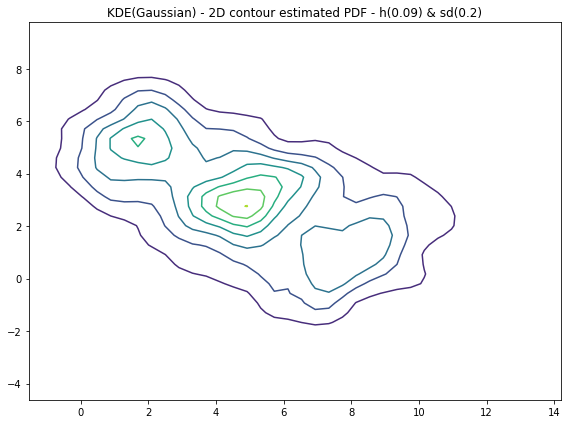

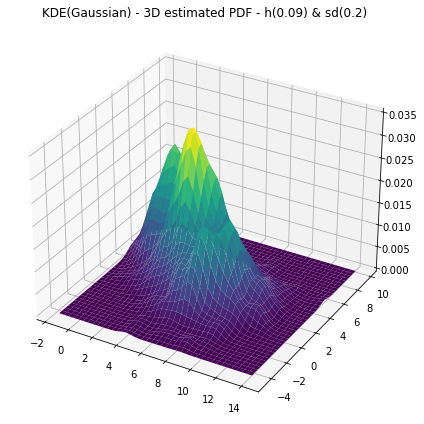

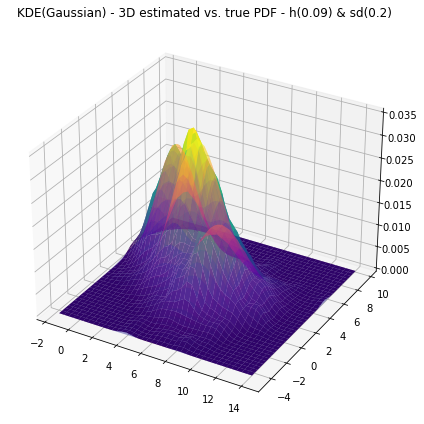

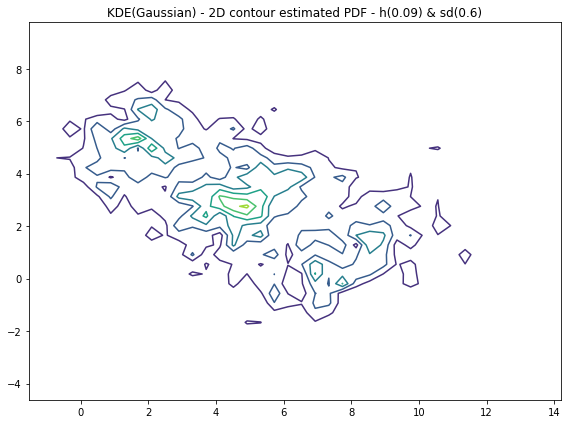

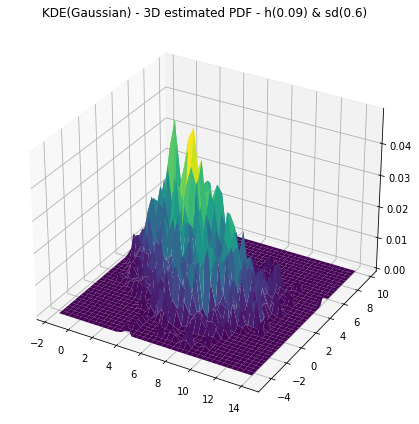

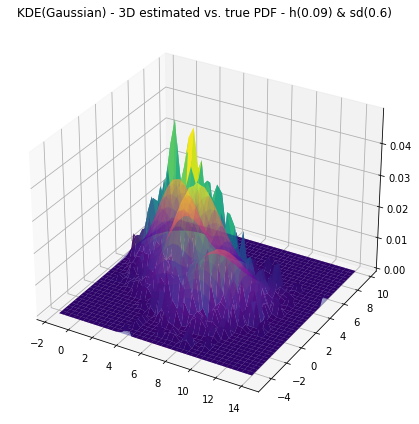

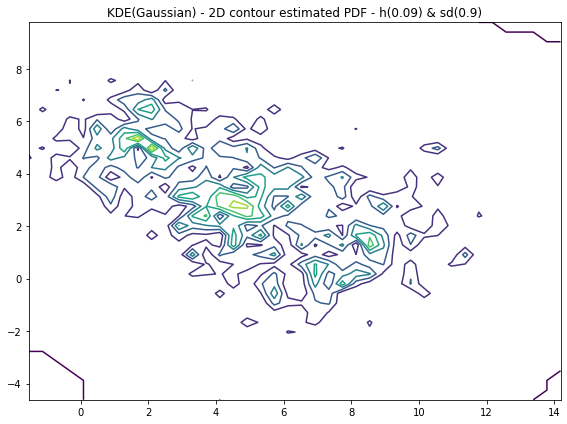

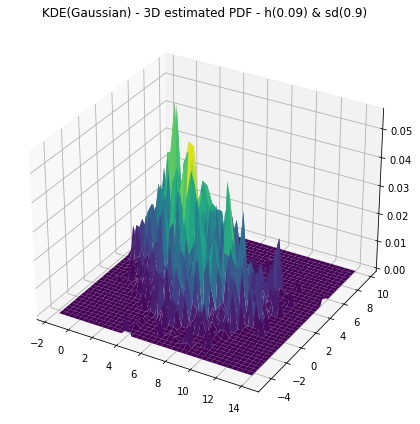

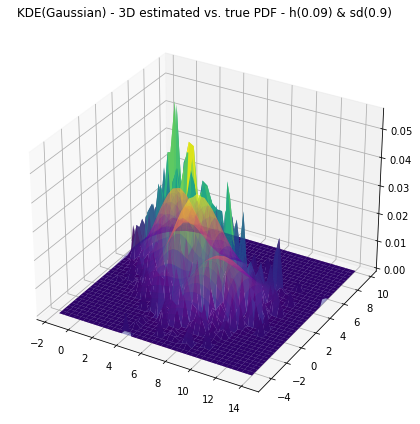

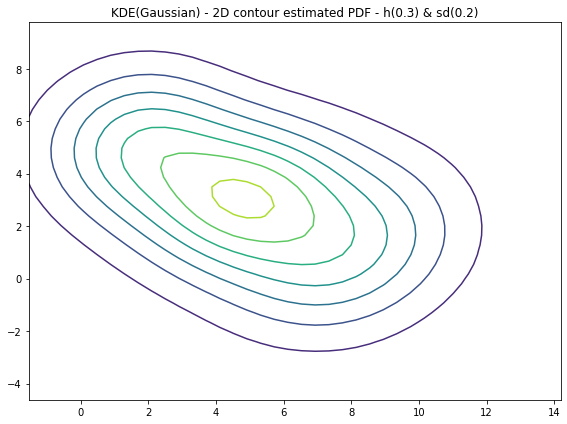

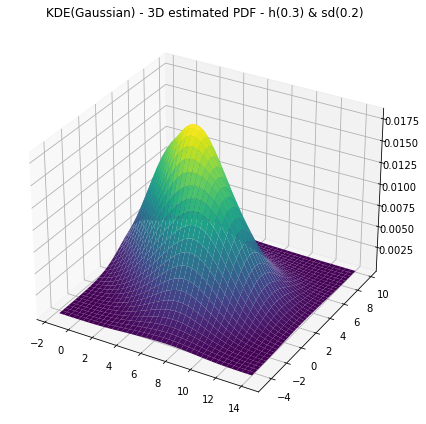

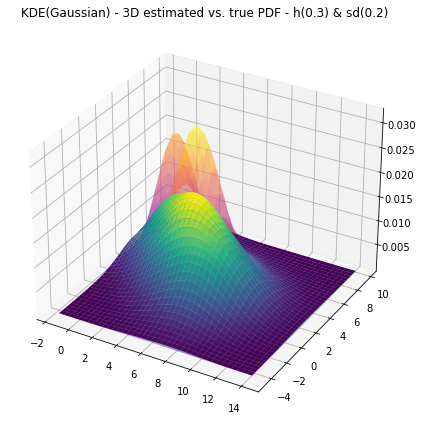

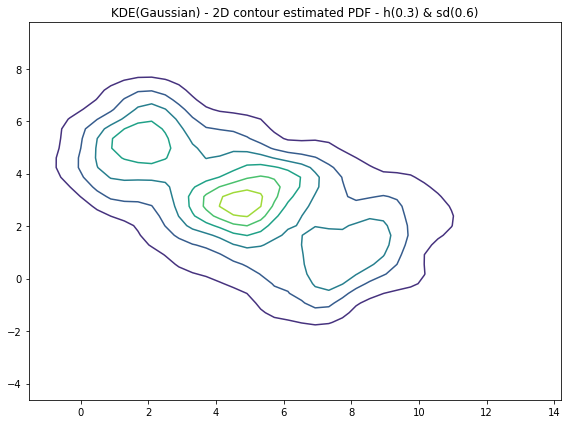

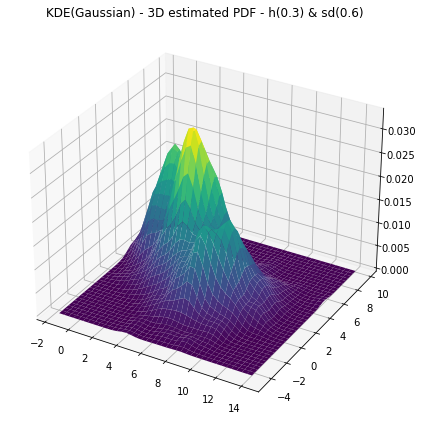

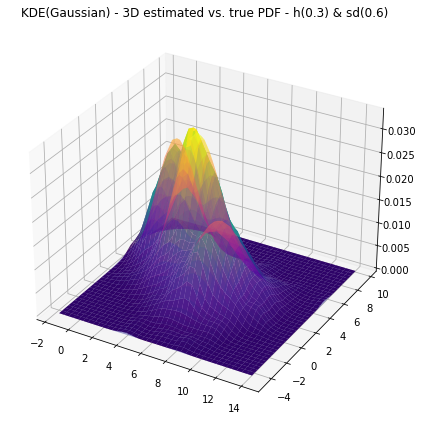

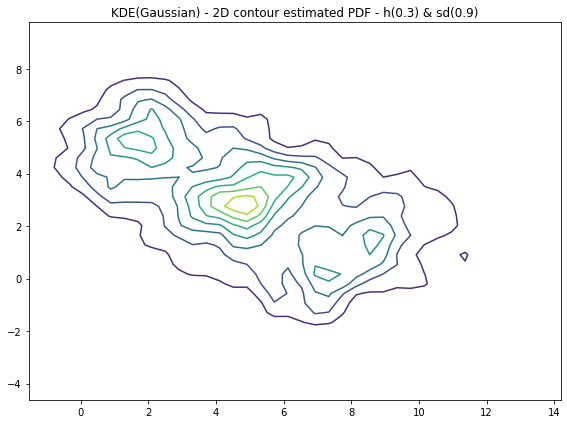

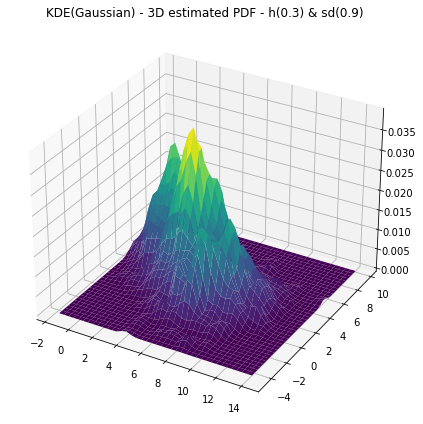

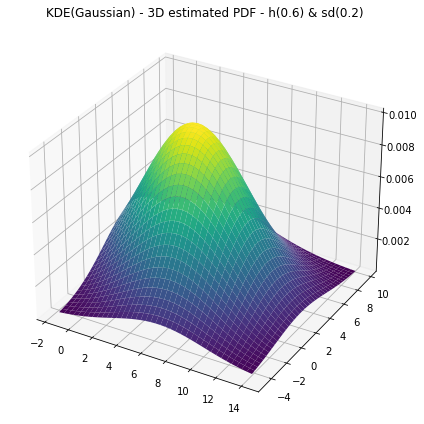

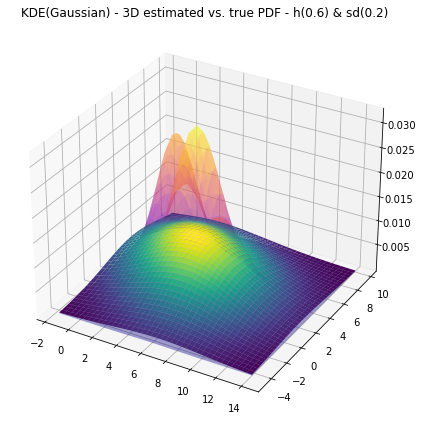

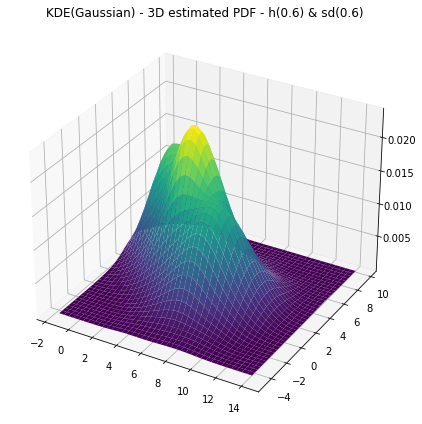

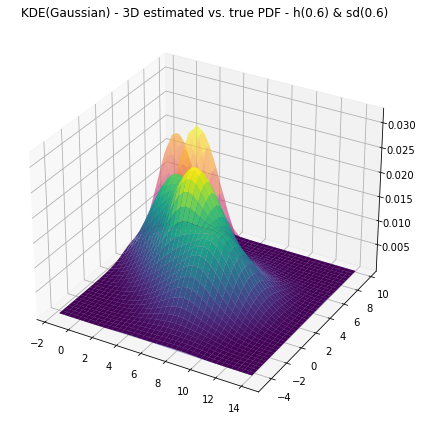

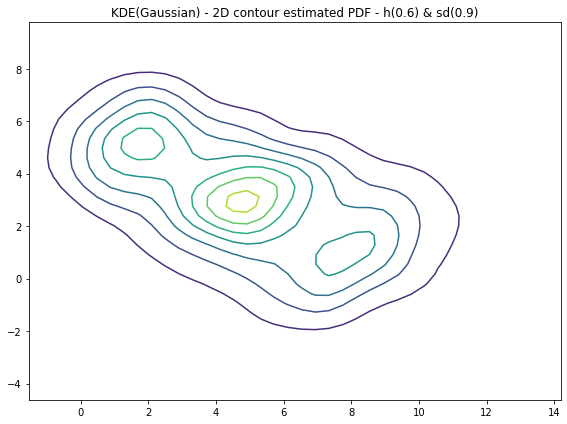

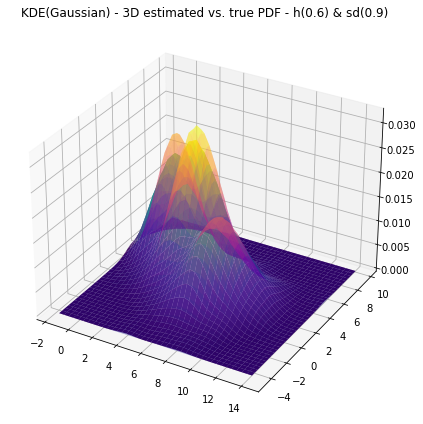

In [179]:
for i, h in enumerate(h_s):
    for j, Z_cord in enumerate(gaussian_probs[h]):
        fig1, ax1 = plt.subplots(1, figsize=(8, 6))
        ax1.contour(X_cord, Y_cord, Z_cord)
        ax1.set_title(f'KDE(Gaussian) - 2D contour estimated PDF - h({str(h_s[i])}) & sd({sd_s[j]})')
        fig1.tight_layout()

        fig2, ax2 = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))
        ax2.plot_surface(X_cord, Y_cord, Z_cord, cmap="viridis")
        ax2.set_title(f'KDE(Gaussian) - 3D estimated PDF - h({str(h_s[i])}) & sd({sd_s[j]})')
        fig2.tight_layout()

        fig3, ax3 = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))
        ax3.plot_surface(X_cord, Y_cord, Z_cord_true, cmap="plasma", alpha=0.4)
        ax3.plot_surface(X_cord, Y_cord, Z_cord, cmap="viridis")
        ax3.set_title(f'KDE(Gaussian) - 3D estimated vs. true PDF - h({str(h_s[i])}) & sd({sd_s[j]})')
        fig3.tight_layout()

In [180]:

def cal_distance(x_points, x, k):
    distances = np.array([np.linalg.norm(i-x) for i in x_points])
    return np.sort(distances)[k-1]

def KNN(X_cord_2d, k):
    N = np.size(X_cord_2d, 1)  
    probs = []  

    for x in X_cord_2d:
        v = math.pi * (cal_distance(X_cord_2d, x, k)**2)
        if v == 0:
            probs.append(1)
        else:
            px = k/(N * v)
            probs.append(px)  

    return probs

In [181]:
KNN_probs = []
k_s = [1, 9, 99]
for k in k_s:
    print(f"calculating probabilities using KNN with k = {k}")
    probs = KNN(X_cord_2d, k)
    Z_cord = np.array(probs).reshape(X_cord.shape)
    KNN_probs.append(Z_cord)

calculating probabilities using KNN with k = 1
calculating probabilities using KNN with k = 9
calculating probabilities using KNN with k = 99


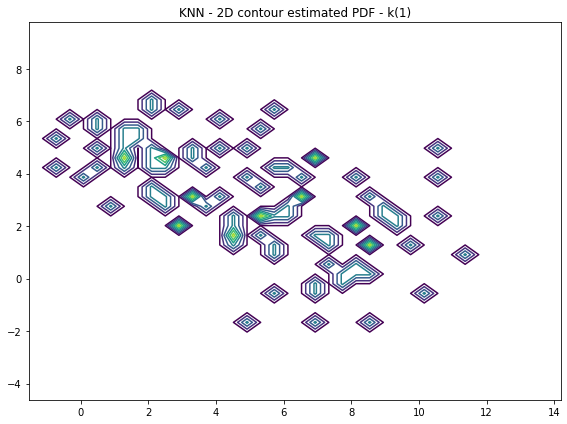

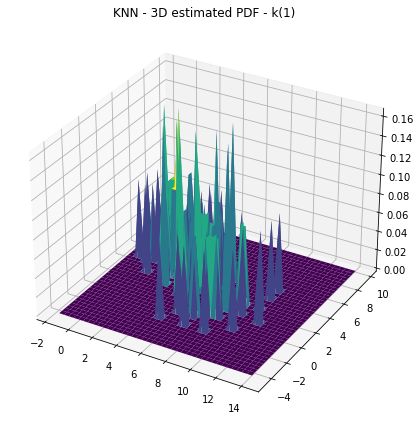

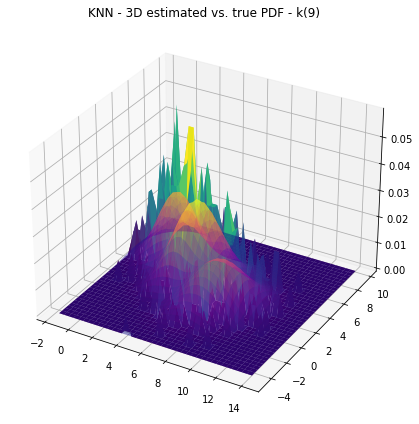

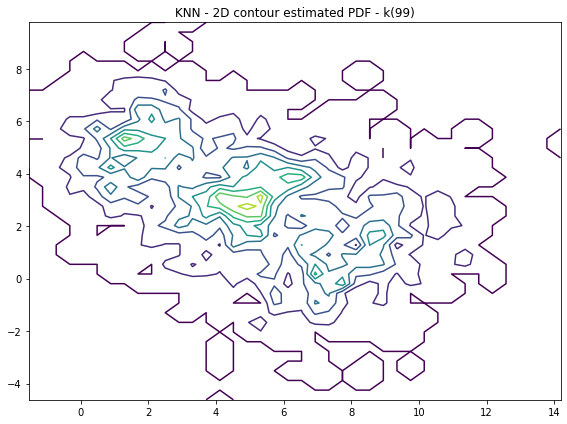

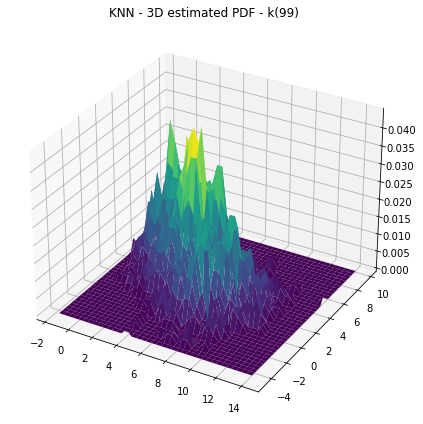

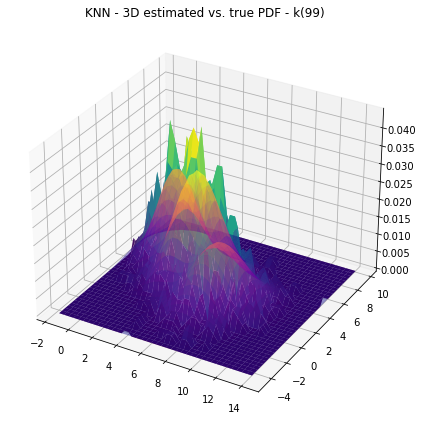

In [182]:
for i in range(len(k_s)):
    fig1, ax1 = plt.subplots(1, figsize=(8, 6))
    ax1.contour(X_cord, Y_cord, parzen_probs[i])
    ax1.set_title(f'KNN - 2D contour estimated PDF - k({str(k_s[i])})')
    fig1.tight_layout()

    fig2, ax2 = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))
    ax2.plot_surface(X_cord, Y_cord, parzen_probs[i], cmap="viridis")
    ax2.set_title(f'KNN - 3D estimated PDF - k({str(k_s[i])})')
    fig2.tight_layout()

    fig3, ax3 = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection="3d"))
    ax3.plot_surface(X_cord, Y_cord, parzen_probs[i], cmap="viridis")
    ax3.plot_surface(X_cord, Y_cord, Z_cord_true, cmap="plasma", alpha=0.45)
    ax3.set_title(f'KNN - 3D estimated vs. true PDF - k({str(k_s[i])})')
    fig3.tight_layout()

In [183]:
def k_fold(data_length, k):
    folds = []
    fold_size = data_length/k
    for i in range(k):
        folds.append([int(i*fold_size),int(((i+1)*fold_size)) - 1])
    return folds

def get_folds(data, k):
    return np.split(data, k)

# copy before shuffling
X_data_cp = X_data
np.random.shuffle(X_data_cp)
folds = get_folds(X_data_cp, 5)
min_err = 1e9
best_h = 0
sigma = 0.6

for h in h_s:
    print(f"Calculating KDE with h = {h} & sigma = {sigma}")
    errs = []
    for i, fold in enumerate(folds):
        print(f'⚠️ Starting fold ({i+1})')
        x = np.linspace(np.min(X_data_cp[:, 0]), np.max(X_data_cp[:, 0]), 30).reshape(-1, 1)
        y = np.linspace(np.min(X_data_cp[:, 1]), np.max(X_data_cp[:, 1]), 30).reshape(-1, 1)
        X_cord, Y_cord = np.meshgrid(x, y)
        X_cord_2d = np.concatenate([X_cord.ravel().reshape(-1, 1), Y_cord.ravel().reshape(-1, 1)], axis=1)
        
        estimated_value = KDE(fold, h, X_cord_2d, sigma, 'gaussian')
        true_value = 0
        for j in range(len(mu_ds_1)):
            true_value += (prior[j] * multivariate_normal(mu_ds_1[j], sigma_ds_1[j]).pdf(X_cord_2d))

        err = np.linalg.norm(true_value-estimated_value)
        errs.append(err)
        print(f'✅ Finished fold ({i+1})')

    err = np.sum(errs) / 5
    print(f'The error calculated for h = {h}: is {round(err, 5)}',)
    if err < min_err:
        min_err = err
        best_h = h

print(f'Best value for h is {best_h} with minimum error of {round(min_err, 5)}')


Calculating KDE with h = 0.09 & sigma = 0.6
⚠️ Starting fold (1)
✅ Finished fold (1)
⚠️ Starting fold (2)
✅ Finished fold (2)
⚠️ Starting fold (3)
✅ Finished fold (3)
⚠️ Starting fold (4)
✅ Finished fold (4)
⚠️ Starting fold (5)
✅ Finished fold (5)
The error calculated for h = 0.09: is 0.20382
Calculating KDE with h = 0.3 & sigma = 0.6
⚠️ Starting fold (1)
✅ Finished fold (1)
⚠️ Starting fold (2)
✅ Finished fold (2)
⚠️ Starting fold (3)
✅ Finished fold (3)
⚠️ Starting fold (4)
✅ Finished fold (4)
⚠️ Starting fold (5)
✅ Finished fold (5)
The error calculated for h = 0.3: is 0.05962
Calculating KDE with h = 0.6 & sigma = 0.6
⚠️ Starting fold (1)
✅ Finished fold (1)
⚠️ Starting fold (2)
✅ Finished fold (2)
⚠️ Starting fold (3)
✅ Finished fold (3)
⚠️ Starting fold (4)
✅ Finished fold (4)
⚠️ Starting fold (5)
✅ Finished fold (5)
The error calculated for h = 0.6: is 0.05401
Best value for h is 0.6 with minimum error of 0.05401
